# Create 'heat' map

This notebook creates the heat map and determines if items are on the wrong side

In [312]:
from model import *
import os # File/directory operations
import ntpath # File/directory operations
import matplotlib
import matplotlib.pyplot as plt
import imageio as imio # Reading images
import glob
from collections import Counter
import itertools
from enum import Enum
import collections
import scipy.misc
from scipy import ndimage
import cv2
import time

dataImPaths = {'XTrain':os.path.abspath(os.path.join('Data','Image','XTrain')),
             'XTest':os.path.abspath(os.path.join('Data','Image','XTest')),
             'yTrain':os.path.abspath(os.path.join('Data','Image','yTrain')),
             'yTest':os.path.abspath(os.path.join('Data','Image','yTest'))}

In [ ]:
imXTrain = glob.glob(os.path.join(dataImPaths['XTrain'], "*"))
imXTest = glob.glob(os.path.join(dataImPaths['XTest'], "*"))

imYTrain = glob.glob(os.path.join(dataImPaths['yTrain'], "*"))
imYTest = glob.glob(os.path.join(dataImPaths['yTest'], "*"))

filePairPathsTrain = list(zip(imXTrain, imYTrain))
filePairPathsTest = list(zip(imXTest, imYTest))

In [ ]:
model = vgg_unet(43, 256, 416)

In [ ]:
model.load_weights('Weights/vgg_unet_1.47-CE-Ext2-Fixed-N.h5')

In [194]:
def evaluateX(model=None, inp_images=None, annotations=None, h=528, w=800):
    ious = []
    uniqueScoreRN = []
    predUniques = []
    trueUniques = []
    for im, an in zip(inp_images, annotations):
        img_true = resize(imio.imread(an), (h / 2, w / 2), mode='edge', anti_aliasing=False,
                          anti_aliasing_sigma=None, preserve_range=True,
                          order=0).astype(int)
        if (img_true.ndim>1):
            img_true = img_true[:,:,0]

        img_pred = model.predict_segmentation(inp=im,out_fname=path_leaf(im))
        #img_pred = model.predict_segmentation(inp=im)
        
        img_true = np.array(img_true).ravel()
        img_pred = np.array(img_pred).ravel()
        iou = jaccard_score(img_true, img_pred, average='micro')
        ious.append(iou)
        
        pu = reduceSSCNoise(img_pred)
        pu.sort()
        
        tu = reduceSSCNoise(img_true,0)
        tu.sort()
        
        predUniques.append(pu)
        trueUniques.append(tu)
        
        
        usRN = SSC(img_true, reduceSSCNoise(img_pred))
        uniqueScoreRN.append(usRN)
    
    return np.mean(ious), np.mean(uniqueScoreRN), predUniques, trueUniques


def path_leaf(path):
    """This function gets the file name from a path"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def getClassFromID(id):
    data = pd.read_csv('Data/classes.csv')
    return data.loc[data['_id'] == id, '_name'].values[0]

def getOutputReport(inp_images, annotations, pUnique, tUnique):
    for i in range(0,len(inp_images)):
        print([getClassFromID(x) for x in tUnique[i]])
        print([getClassFromID(x) for x in pUnique[i]])
        
def segmentImage(model, inp_images):
    pred = model.predict_segmentation(inp=inp_images)
    return pred, reduceSSCNoise(pred)

db = pd.read_csv('Data/classes.csv')

class Color(Enum):
    Ignore = 1
    Hot = 2
    Cold = 3
    
cols = {
    Color.Ignore:100,
    Color.Cold:128,
    Color.Hot:256
}

def getClassHeatValue(database, inCls):
    hot = database.loc[database['_id'] == inCls, '_hot'].values[0]
    cold = database.loc[database['_id'] == inCls, '_cold'].values[0]
    if (hot == 1 and cold == 1):
        # you're hot then you're cold
        return Color.Ignore        
    if (hot == 1 and cold != 1):
        # you're yes then you're no
        return Color.Hot   
    else:
        return Color.Cold
    

def generateHeatMap(seg,uni):
    base = np.zeros((seg.shape[0],seg.shape[1]),dtype=np.uint)
    for u in uni:
        if(u != 0):            
            test = seg == u
            base[test] = cols[getClassHeatValue(db,u)]
    base = ndimage.gaussian_filter(base, sigma=1)
    
    return base

def identifyHeatColdIntersections(hmap):
    base = np.zeros((hmap.shape[0],hmap.shape[1]),dtype=np.uint)
    test = np.logical_and(hmap > cols[Color.Cold],hmap < cols[Color.Hot])
    base[test] = 255  
    base = ndimage.gaussian_filter(base, sigma=1)
    return base

def determineHeatColdIntersectionIssues(intersection):
    wh = int(round(intersection.shape[1]/2))
    h1 = intersection[:,:wh]
    h2 = intersection[:,wh:]
    h1a = np.average(h1)
    h2a = np.average(h2)
    if (h1a > h2a):
        h1 = np.zeros(h1.shape, dtype=np.uint)
        if(h2a>0):
            h2 = removeSmallBlobs(h2,h2a)
    else:
        h2 = np.zeros(h2.shape, dtype=np.uint) 
        if(h1a>0):
            h1 = removeSmallBlobs(h1,h1a)    
    
    return np.concatenate((h1, h2), axis=1)

def removeSmallBlobs(img,avr,threh=0.01):
    if(threh<avr):
        return img
    else:
        return np.zeros((img.shape[0],img.shape[1]),dtype=np.uint)

In [195]:
# iou, ssc, predunique, trueUnique = evaluateX(model,imXTest,imYTest,256,416)
# getOutputReport(imXTest,imYTest, predunique, trueUnique)

In [313]:
start = time.time()
arr, uni = segmentImage(model, imXTest[0])
end = time.time()
print(end - start)

0.524172306060791


In [314]:
start = time.time()
hMap = generateHeatMap(arr,uni)
end = time.time()
print(end - start)

0.012421607971191406


In [315]:
start = time.time()
hMap1 = identifyHeatColdIntersections(hMap)
end = time.time()
print(end - start)

0.0026807785034179688


In [316]:
start = time.time()
dx = determineHeatColdIntersectionIssues(hMap1)
end = time.time()
print(end - start)

0.0


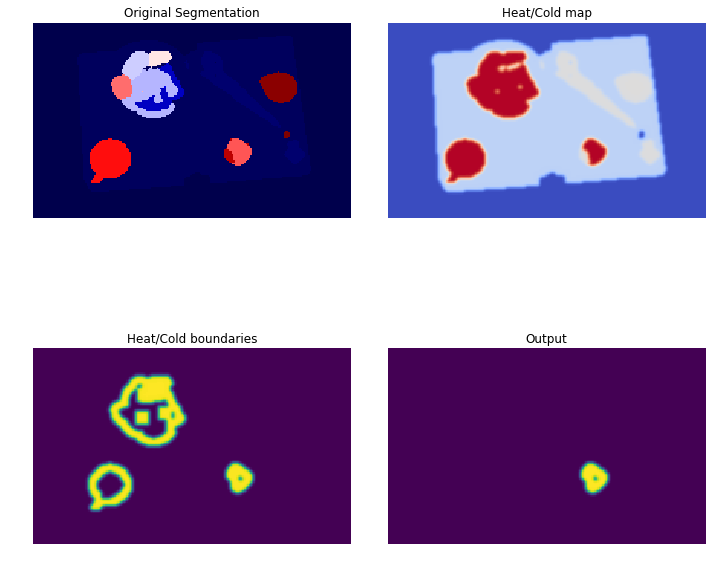

In [317]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

fig, axes = plt.subplots(nrows=2, ncols=2)
ax = axes.ravel()

ax[0].imshow(arr,cmap='seismic')
ax[0].set_title("Original Segmentation")
ax[0].axis('off')
ax[1].imshow(hMap,cmap='coolwarm')
ax[1].set_title("Heat/Cold map")
ax[1].axis('off')
ax[2].imshow(hMap1)
ax[2].set_title("Heat/Cold boundaries")
ax[2].axis('off')
ax[3].imshow(dx)
ax[3].set_title("Output")
ax[3].axis('off')
plt.tight_layout()

plt.show()